# The LANL data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import re

from __future__ import print_function
from math import log, pow
from collections import Counter

dnsfile = lanl_path + "dns.txt"
flowfile = lanl_path + "flows.txt"
procfile = lanl_path + "proc.txt"

See <a href="http://csr.lanl.gov/data/cyber1/">http://csr.lanl.gov/data/cyber1/</a> for the original data descriptions and download.

# Flows

Start by parsing the flow data and inspecting a few records:

In [3]:
def flow_parser(x): return  [int(x[0]), int(x[1])] \
                + [str(x[i]) for i in range(2,6)] \
                + [int(x[i]) for i in range(6,9)]

flows = sc.textFile(flowfile)\
    .map(lambda line: flow_parser(line.split(',')))
flows.cache()

flows.take(10)

[[1, 0, 'C1065', '389', 'C3799', 'N10451', 6, 10, 5323],
 [1, 0, 'C1423', 'N1136', 'C1707', 'N1', 6, 5, 847],
 [1, 0, 'C1423', 'N1142', 'C1707', 'N1', 6, 5, 847],
 [1, 0, 'C14909', 'N8191', 'C5720', '2049', 6, 1, 52],
 [1, 0, 'C14909', 'N8192', 'C5720', '2049', 6, 1, 52],
 [1, 0, 'C14909', 'N8193', 'C5720', '2049', 6, 1, 52],
 [1, 0, 'C1707', 'N1', 'C1423', 'N1136', 6, 4, 414],
 [1, 0, 'C1707', 'N1', 'C1423', 'N1142', 6, 4, 413],
 [1, 0, 'C1707', 'N1', 'C925', 'N10487', 6, 4, 414],
 [1, 0, 'C1707', 'N1', 'C925', 'N10491', 6, 4, 413]]

Fields are:

<ul>
<li> timestamp
<li> flow duration
<li> sourse computer
<li> source port
<li> destination computer
<li> destination port
<li> protocol
<li> number of packets
<li> number of bytes
</ul>

Let's take an initial look at some of these:

<Container object of 3 artists>

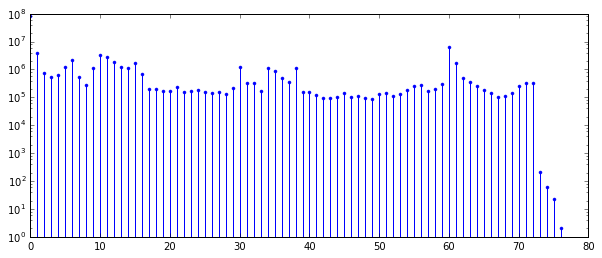

In [43]:
# duration:

duration_hist = flows.map(lambda x: x[1]).countByValue()

plt.figure(figsize=(10,4))
plt.yscale('log')
plt.stem(duration_hist.keys(), duration_hist.values(), markerfmt='b.')

Two things stand out: first, the spikes in frequency at certain 'round' duration times ()10, 30, 60 seconds - suggesting a configuration bias in the collection process. Second, the unnatural drop-off at 72 seconds - this looks like a weird cut-off rule in the collection, since most flows would be expected to need longer than a minute to completion. I'm inclined to discount the duration field in further analysis.

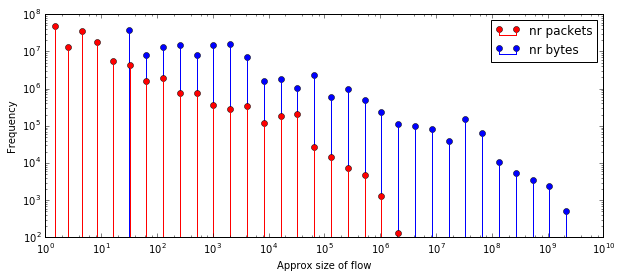

In [129]:
# packets and bytes:

packet_hist = flows.map(lambda x: int(log(x[7], 2))).countByValue()
bytes_hist = flows.map(lambda x: int(log(x[8], 2))).countByValue()

plt.figure(figsize=(10,4))
plt.xscale('log')
plt.yscale('log')
x = [pow(2,t)+0.5 for t in packet_hist.keys()]
y = [pow(2,t) for t in bytes_hist.keys()]
h2 = plt.stem(y, bytes_hist.values(), markerfmt='bo', linefmt='b-', basefmt='b-', label='nr bytes')
h1 = plt.stem(x, packet_hist.values(), markerfmt='ro', linefmt='r-', basefmt='r-', label='nr packets')
plt.xlabel("Approx size of flow")
plt.ylabel("Frequency")
plt.legend(handles=[h1, h2], loc='upper right')
plt.show()

These are typical power law distributions we'd expect to see in the distributions of packet and byte counts. These plot don't show whether number of packets/bytes are correlated - we can see that in a 2D heat map: 

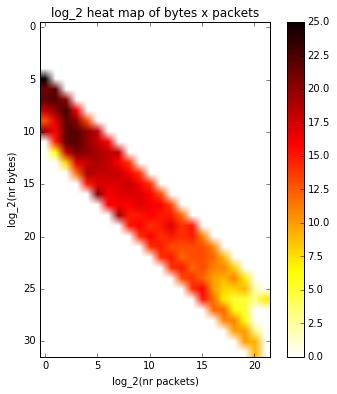

In [175]:
# how many bytes per packet?

packet_byte_2d_hist = flows.map(lambda x: (int(log(x[7], 2)), int(log(x[8], 2)))).countByValue()

a = set([x[0] for x in packet_byte_2d_hist.keys()])
b = set([x[1] for x in packet_byte_2d_hist.keys()])

mat = np.array([[0 for j in range(max(b) + 1)] for i in range(max(a) + 1)])
for (i,j) in packet_byte_2d_hist.keys():
    mat[i,j] = log(packet_byte_2d_hist[(i,j)], 2)
    
plt.figure(figsize=(6,6))
plt.xlabel("log_2(nr packets)")
plt.ylabel("log_2(nr bytes)")
plt.title("log_2 heat map of bytes x packets")
plt.imshow(mat.transpose(), cmap='hot_r')
plt.colorbar()

So there's a clean linear correlation, with all flows exhibiting an <i>average</i> packet size (i.e. nr bytes/nr packets) between 32 and 1024 bytes.

Next, examine the protocol field:

In [70]:
# protocol:

protocol_hist = flows.map(lambda x: x[6]).countByValue()

n = sum(protocol_hist.values())
for p in sorted(protocol_hist.keys()):
    print('{0:2d}: {1:10d}  {2:2.3}%'.format(p, protocol_hist[p], 100.0*protocol_hist[p]/n))

 1:    3321625  2.56%
 6:  116550579  89.7%
17:   10104702  7.77%
41:        506  0.000389%


Protocols 1, 6, 17, 41 denote ICMP, TCP, UDP and IPv6 encapsulation respectively. (See this <a href="https://en.wikipedia.org/wiki/List_of_IP_protocol_numbers">Wikipedia guide</a>.)

We now compare the two columns 'src' and 'dst'. Observing that the values are essential drawn from the same set, it follows that this pair of columns naturally defines edges of a graph (weighted by frequency):

In [20]:
# computers:

computer_edgelist = flows.map(lambda x: (x[2], x[4])).countByValue()

src_set = set([x[0][0] for x in computer_edgelist.items()])
dst_set = set([x[0][1] for x in computer_edgelist.items()])

print("Sources:     ", len(src_set))
print("Destinations: ", len(dst_set))
print("Union:       ", len(src_set.union(dst_set)))
print("Intersection: ", len(src_set.intersection(dst_set)))

Sources:      11154
Destinations:  8711
Union:        12027
Intersection:  7838


We can check elementary properties of this graph, such as connectivity:

In [98]:
# to use Python igraph (compared with R) we have to write our own vertex indexing (?!)

nv = len(src_set.union(dst_set))
vlookup = dict(zip(range(nv), list(src_set.union(dst_set))))
ilookup = dict(zip(list(src_set.union(dst_set)), range(nv)))
elist = [[ilookup[k[0]], ilookup[k[1]]] for k in computer_edgelist.keys()]

flow_graph = ig.Graph(nv)
flow_graph.add_edges(elist)

flow_graph.is_connected()

True

We could in principle get further information 'for free' from these graphs. For example, restricting the computer-to-computer graph to records with <i>proto = 1</i> (that is, ICMP flows) gives some immediate clustering:
<img src="img/icmp_graph.png" style="width:500px" align="left">


But let's not pursue that here. Instead, compare the source and destination port fields. The port values are all either '\d+' (actual) or 'N\d+' (anonymised). We'll cheat a bit and assume this is known, and normalise the anonymised ones to a single value.

In [9]:
# ports:

def normalise(s):
    if re.search('^N', s): return 'N'
    else: return s

port_edgelist = flows\
                .map(lambda x: (normalise(x[3]), normalise(x[5])))\
                .countByValue()    

src_pt_set = set([x[0] for x in port_edgelist.keys()])
dst_pt_set = set([x[1] for x in port_edgelist.keys()])
int_pt_set = src_pt_set.intersection(dst_pt_set)

print("Sources:      ", len(src_pt_set))
print("Destinations: ", len(dst_pt_set))
print("Union:        ", len(src_pt_set.union(dst_pt_set)))
print("Intersection: ", len(int_pt_set))

Sources:       324
Destinations:  326
Union:         326
Intersection:  324


In [129]:
flows.unpersist()

PythonRDD[2] at RDD at PythonRDD.scala:43

# DNS

In [130]:
def dns_parser(x): return [int(x[0])] \
               + [str(x[i]) for i in range(1,len(x))]

dns = sc.textFile(dnsfile)\
    .map(lambda line: dns_parser(line.split(',')))
dns.take(10)

[[2, 'C4653', 'C5030'],
 [2, 'C5782', 'C16712'],
 [6, 'C1191', 'C419'],
 [15, 'C3380', 'C22841'],
 [18, 'C2436', 'C5030'],
 [31, 'C161', 'C2109'],
 [35, 'C5642', 'C528'],
 [38, 'C3380', 'C22841'],
 [42, 'C2428', 'C1065'],
 [42, 'C2428', 'C2109']]

Fields are:

<ul>
<li> timestamp
<li> requesting computer
<li> requested computer
</ul>

We'll focus on the computers and return to consider timestamps in the second notebook.

As for flows, we can observe that two columns take values in (essentially) the same set, and hence define a graph:

In [132]:
# computers:

dns_edgelist = dns.map(lambda x: (x[1], x[2])).countByValue()

dns_src_set = set([x[0][0] for x in dns_edgelist.items()])
dns_dst_set = set([x[0][1] for x in dns_edgelist.items()])

print("Sources:      ", len(dns_src_set))
print("Destinations: ", len(dns_dst_set))
print("Union:        ", len(dns_src_set.union(dst_set)))
print("Intersection: ", len(dns_src_set.intersection(dst_set)))

Sources:       15013
Destinations:  13776
Union:         15329
Intersection:  13493


In [158]:
self_dns = dns.filter(lambda x: x[1]==x[2]).collect()
nr_dns = dns.count()

print("Nr DNS requests:", nr_dns)
print("Nr self-requests: ", len(self_dns))
print("Nr computers:      ", len(dns_src_set.union(dst_set)))
print("Nr self-requesters: ", len(set([x[1] for x in self_dns])))

Nr DNS requests: 40821591
Nr self-requests:  865039
Nr computers:       15329
Nr self-requesters:  1434


In [160]:
# the graph:

dns_nv = len(dns_src_set.union(dns_dst_set))
dns_vlookup = dict(zip(range(dns_nv), list(dns_src_set.union(dns_dst_set))))
dns_ilookup = dict(zip(list(dns_src_set.union(dns_dst_set)), range(dns_nv)))
dns_elist = [[dns_ilookup[k[0]], dns_ilookup[k[1]]] for k in dns_edgelist.keys()]

dns_graph = ig.Graph(dns_nv)
dns_graph.add_edges(dns_elist)

dns_graph.is_connected()

False

Though in this case further analysis shows that the graph is connected apart from a single singleton node that is self-requesting - not unusual in the data, but other self-requesters are also connected to the main graph.

But let's move on.

# Processes

The original data in this file looks like:

<code>
1,C553$@DOM1,C553,P16,Start
1,C553$@DOM1,C553,P25,End
1,C553$@DOM1,C553,P25,Start
</code>

So we either have to learn that every record takes roughly this form, or we assume it's known. We'll break out the second column into two fields separated by '@':

In [10]:
def proc_parser(x):
    n = len(x)
    return  [int(x[0])] + str(x[1]).split('@') + [str(x[i]) for i in range(2,n)]

procs = sc.textFile(procfile)\
    .map(lambda line: proc_parser(line.split(',')))
procs.take(10)

[[1, 'C1$', 'DOM1', 'C1', 'P16', 'Start'],
 [1, 'C1001$', 'DOM1', 'C1001', 'P4', 'Start'],
 [1, 'C1002$', 'DOM1', 'C1002', 'P4', 'Start'],
 [1, 'C1004$', 'DOM1', 'C1004', 'P4', 'Start'],
 [1, 'C1017$', 'DOM1', 'C1017', 'P4', 'Start'],
 [1, 'C1018$', 'DOM1', 'C1018', 'P4', 'Start'],
 [1, 'C1020$', 'DOM1', 'C1020', 'P3', 'Start'],
 [1, 'C1020$', 'DOM1', 'C1020', 'P4', 'Start'],
 [1, 'C1028$', 'DOM1', 'C1028', 'P16', 'End'],
 [1, 'C1029$', 'DOM1', 'C1029', 'P4', 'Start']]

Fields are:

<ul>
<li> timestamp
<li> user
<li> domain
<li> computer
<li> process id
<li> start/end
</ul>

Let's check the frequency distribution for values of the domain/computer/process columns. We also include the flow edges (computed earlier):

Nr domains:     10259
Nr computers:   11960
Nr processes:   62974
Nr flow edges: 162157


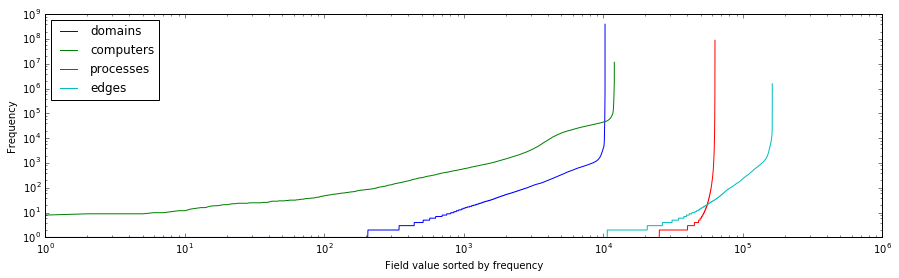

In [21]:
domains = procs.map(lambda x: x[2]).countByValue()
computers = procs.map(lambda x: x[3]).countByValue()
processes = procs.map(lambda x: x[4]).countByValue()

print("Nr domains:    ", len(domains.keys()))
print("Nr computers:  ", len(computers.keys()))
print("Nr processes:  ", len(processes.keys()))
print("Nr flow edges:", len(computer_edgelist.keys()))

plt.figure(figsize=(15,4))
plt.xscale("log")
plt.yscale("log")
p1, = plt.plot(sorted(domains.values()), label="domains")
p2, = plt.plot(sorted(computers.values()), label="computers")
p3, = plt.plot(sorted(processes.values()), label="processes")
p4, = plt.plot(sorted(computer_edgelist.values()), label="edges")
plt.legend(handles=[p1,p2,p3,p4], loc='upper left')
plt.xlabel("Field value sorted by frequency")
plt.ylabel("Frequency")
plt.show()

In [205]:
computer_busyness = 1e05
edge_busyness = 2e04

busy_computers = set([k for k in computers.keys() if computers[k] > computer_busyness])
busy_edges = set([k for k in computer_edgelist.keys() if computer_edgelist[k] > edge_busyness])
busy_nodes = set([e[0] for e in busy_edges]).union(set([e[1] for e in busy_edges]))

print("Network-busy pairs:    ", len(busy_edges))
print("Network-busy computers:", len(busy_nodes))
print("Process-busy computers:", len(busy_computers))
print("Union:                 ", len(busy_computers.union(busy_nodes)))
print("Intersection:           ", len(busy_computers.intersection(busy_nodes)))

Network-busy pairs:     308
Network-busy computers: 250
Process-busy computers: 296
Union:                  531
Intersection:            15


In [209]:
heavy_hitters = busy_computers.intersection(busy_nodes)
print(heavy_hitters)

set(['C6055', 'C2321', 'C12665', 'C1065', 'C2519', 'C674', 'C10089', 'C3173', 'C1707', 'C1685', 'C2696', 'C14714', 'C14870', 'C1654', 'C458'])


How many values in the 'domain' field, and what do they look like?

In [17]:
# domains:

import re

domains = procs.map(lambda x: x[2])
domain_hist = domains.countByValue()

print("Nr domains: ", len(domain_hist.keys()), "\n")
for x in sorted(domain_hist.keys(), key=lambda k: domain_hist[k], reverse=True):
    if not re.search('^C\d+', x):
        print('{0:7s}: {1:10d}'.format(x, domain_hist[x]))

Nr domains:  10259 

DOM1   :  395959855
DOM3   :     620713
DOM4   :     138989
DOM5   :      89532
DOM6   :      46118
DOM2   :      30620
DOM51  :      15955
DOM267 :       1848
DOM106 :        654
DOM178 :        464
DOM316 :        463
DOM42  :        444
DOM256 :        365
DOM214 :        305
DOM85  :        207
DOM121 :        204
DOM277 :        158
DOM55  :        153
DOM274 :        113
DOM276 :         91
DOM273 :         72
DOM91  :         70
DOM272 :         68
DOM296 :         66
DOM246 :         57
DOM236 :         57
DOM351 :         56
DOM186 :         53
DOM210 :         39
DOM247 :         39
DOM27  :         19
DOM43  :          1
DOM38  :          1
DOM33  :          1


Domain frequency has (as we'd expect) a power law distribution. 'DOM1' is the giant far out on lower right:

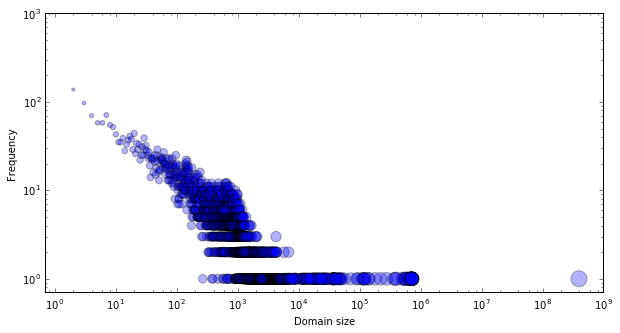

In [18]:
freq = Counter(domain_hist.values())

fig = plt.figure(figsize=(10,5))
size = [30*log(x,10) for x in freq.keys()]
plt.xlim(xmin=7e-01, xmax=1e09)
plt.ylim(ymin=7e-01, ymax=1e03)
plt.yscale('log')
plt.xscale('log')
plt.scatter(freq.keys(), freq.values(), s=size, alpha=0.3)
plt.xlabel("Domain size")
plt.ylabel("Frequency")

<h2>Conclusions</h2>

We examine three data sets of computer network activity:

<ol>
<li> flows: 5.24 GB, 130M events
<li> processes: 15.4GB, 426M events
<li> DNS requests: 813 MB, 40M events.
</ol>

<h2>TADA: meeting the data</h2>

These data sets are in tabular form without missing values. (In general, one should deal also with .json and similar formats, and with images and unstructured text as well.) They are anonymised, which gives us the additional challenge of recovering structure that is supposedly removed by the anonymisation where we can.

In initial exploration of the data, the sorts of things we need to automate and provide to the user 'free of charge' are discovery and presentation of:

<ul>
<li> any numerical fields, especially timestamps (see next notebook);
<li> statistical distributions in numerical fields including outliers and anomalous boundaries;
<li> numerical correlations among fields;
<li> frequency distributions in categorical fields;
<li> categorical fields drawing from common alphabets;
<li> string structure in categorical labels (e.g. regular expression characterisations);
<li> heavy hitters in power law distributions, including decisions on hard or soft thresholds;
<li> graph structures that occur in the data, and elementary graph features.
</ul>

A key aspect is visualisation. The human analytic process (what to compute, where to go next) is fundamentally driven by data visualisation. ADAP needs, on the one hand, to remove the need for visualisation in analytic decision-making, while on the other hand presenting its findings via appropriate visualisations.

When ADAP reports on a data set, what format would we like for the output? How about a Jupyter notebook! 